##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 过拟合与欠拟合

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/tutorials/keras/overfit_and_underfit"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在  TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

与往常一样，本示例中的代码将使用 `tf.keras` API，您可以通过 TensorFlow [Keras 指南](https://tensorflow.google.cn/guide/keras)了解详细信息。

在之前的两个示例（[文本分类](text_classification_with_hub.ipynb)和[预测燃油效率](regression.ipynb)）中，可以看到模型在验证数据上的准确率会在经过多个周期的训练后达到峰值，然后便停滞不前或开始下降。

换句话说，模型会对训练数据*过拟合*。学习如何处理过拟合很重要。尽管模型通常可以在*训练集*上达到很高的准确率，但我们真正想要的是开发出能很好地泛化到*测试集*（或之前未见过的数据）的模型。

过拟合的反面是*欠拟合*。当在测试数据上仍有改进空间时就会发生欠拟合。出现这种情况的原因有很多：模型不够强大、过度正则化，或者只是训练时间不够长。这种情况意味着网络尚未学习训练数据中的相关模式。

但如果训练时间过长，模型则会开始过拟合，并从训练数据中学习无法泛化到测试数据的模式。我们需要找到平衡点。了解如何训练合适数量的周期（将在下文进行探讨）是一项十分有用的技能。

要防止过拟合，最好的解决方案是使用更完整的训练数据。数据集应该涵盖模型要处理的所有输入。其他数据可能只有在涉及新的值得关注的情况时才有用。

在更完整的数据上训练的模型自然能更好地进行泛化。如果没有更完整的数据，则第二好的解决方案是使用正则化之类的技术。这些技术限制了模型可以存储的信息的数量和类型。如果网络只能记住少量的模式，则优化过程将迫使其关注最突出的模式，这些模式将有机会获得更好地泛化。

在此笔记本中，您将探索几种常见的正则化技术，并使用这些技术改进分类模型。

## 设置

在开始之前，请导入必要的软件包：

In [3]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.19.0


In [4]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /private/var/folders/g8/ldvmc96x1j71cj1cn18bspwc0000gn/T/pip-req-build-2l9kyp7s
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /private/var/folders/g8/ldvmc96x1j71cj1cn18bspwc0000gn/T/pip-req-build-2l9kyp7s
  Resolved https://github.com/tensorflow/docs to commit de223126b8f1c5365f935e687b56518cf256b4b6
  Preparing metadata (setup.py) ... done
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
  DEPRECATION: Building 'tensorflow-docs' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'tensorflow-docs'. Discussion can be found at https://github.

In [5]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [6]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## 希格斯数据集

本教程的目的不是粒子物理学，因此无需关注数据集的细节。它包含 11,000,000 个样本，每个样本有 28 个特征和一个二元类标签。

In [7]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 ━━━━━━━━━━━━━━━━━━━━ 1070s 0us/step


In [8]:
FEATURES = 28

`tf.data.experimental.CsvDataset` 类可用于直接从 Gzip 文件读取 CSV 记录，而无需中间的解压步骤。

In [9]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

CSV 读取器类会为每条记录返回一个标量列表。下面的函数会将此标量列表重新打包为 (feature_vector, label) 对。

In [10]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow 在运算大批次数据时效率最高。

因此，不要单独重新打包每一行，而是创建一个新的 `tf.data.Dataset`，该数据集会接收以 10,000 个样本为单位的批次，将 `pack_row` 函数应用于每个批次，然后将批次重新拆分为单个记录：

In [11]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

检查这个新的 `packed_ds` 中的一些记录。

虽然特征没有完全归一化，但对本教程而言已经足够了。

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


2025-07-07 21:16:11.311199: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


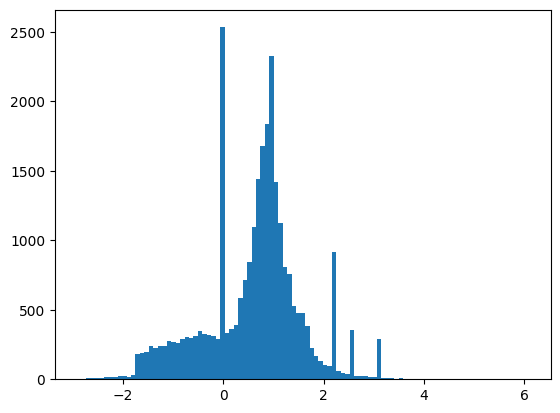

In [12]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

为了缩短本教程的篇幅，我们只使用前 1,000 个样本进行验证，再用接下来的 10,000 个样本进行训练：

In [13]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

`Dataset.skip` 和 `Dataset.take` 方法能够使这项操作变得容易。

同时，使用 `Dataset.cache` 方法来确保加载器无需每个周期都需要从文件重新读取数据。

In [14]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [15]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

这些数据集会返回单个样本。使用 `Dataset.batch` 方法创建适当大小的批次进行训练。在创建批次之前，还要记得在训练集上使用 `Dataset.shuffle` 和 `Dataset.repeat`。

In [16]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## 演示过拟合

要避免过拟合，最简单的方法是从小模型开始。小模型是指具有少量可学习参数（由层数和每层的单元数决定）的模型。在深度学习中，模型中可学习参数的数量通常被称为模型的“容量”。

凭直觉来看，模型的参数越多，“记忆容量”就越大，于是就能够轻松学习训练样本与其目标之间的字典式完美映射（这种映射没有任何泛化能力），但这在对以前未曾见过的数据进行预测时毫无用处。

请务必牢记：深度学习模型往往擅长拟合训练数据，但真正的挑战是泛化而非拟合。

另一方面，如果网络的记忆资源有限，便无法轻松学习映射。为了使损失最小化，它必须学习具有更强预测能力的压缩表示。同时，如果模型太小，则很难与训练数据拟合。我们需要找到“容量过剩”和“容量不足”之间的平衡点。

遗憾的是，没有什么神奇的公式可以确定模型的正确大小或架构（层数或每层的正确大小）。您必须用一系列不同的架构进行试验。

要找到合适的模型大小，最好先使用相对较少的层和参数，然后增加层的大小或添加新层，直到看到返回的验证损失逐渐减小。

先从仅使用密集连接层 (`tf.keras.layers.Dense`) 作为基线的简单模型开始，然后创建更大的模型并进行对比。

### 训练过程

如果在训练期间逐渐减小学习率，许多模型的训练效果会更好。请使用 `tf.keras.optimizers.schedules` 随着时间的推移减小学习率：

In [17]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

上述代码设置了一个 `tf.keras.optimizers.schedules.InverseTimeDecay`，用于在 1,000 个周期时将学习率根据双曲线的形状降至基础速率的 1/2，在 2,000 个周期时将至 1/3，依此类推。

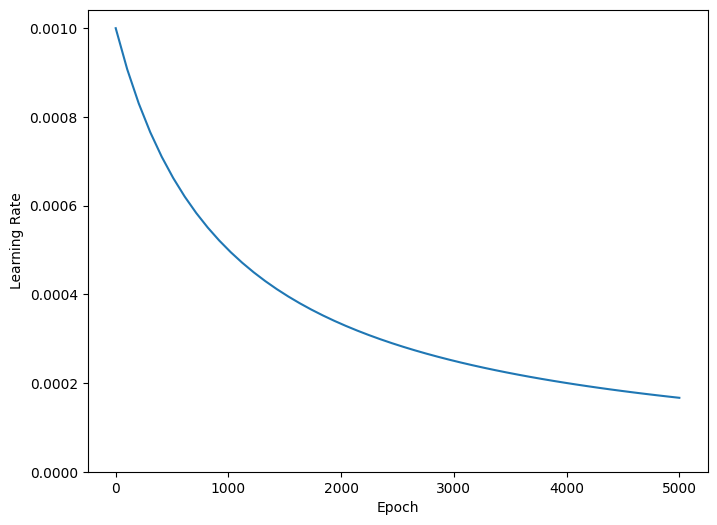

In [18]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


本教程中的每个模型都将使用相同的训练配置。因此，从回调列表开始，以可重用的方式对其进行设置。

本教程的训练会运行许多个较短周期。为了降低日志记录噪声，请使用 `tfdocs.EpochDots`，它仅会为每个周期打印一个 `.`，并每隔 100 个周期打印一整套指标。

然后，添加 `tf.keras.callbacks.EarlyStopping` 以避免冗长和不必要的训练时间。请注意，设置此回调是为了监视 `val_binary_crossentropy`，而不是 `val_loss`。这个区别在后面会很重要。

使用 `callbacks.TensorBoard` 为训练生成 TensorBoard 日志。


In [19]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

类似地，每个模型将使用相同的 `Model.compile` 和 `Model.fit` 设置：

In [20]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### 微模型

从训练下面的模型开始：

In [21]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

/opt/anaconda3/envs/TensorFlow/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
size_histories = {}

In [23]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 1)

现在查看一下模型的表现：

(0.5, 0.7)

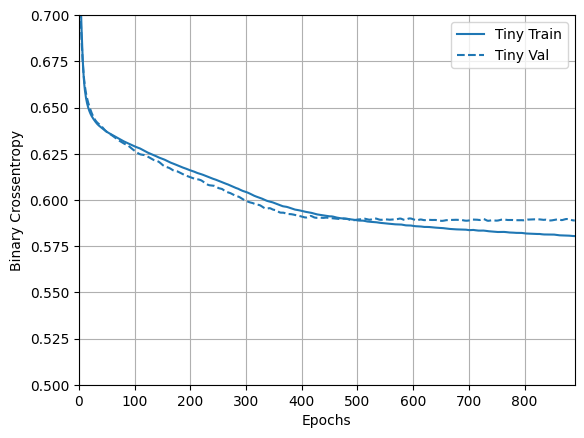

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### 小模型

要检查能否超过小模型的表现，需要逐步训练一些较大的模型。

请尝试两个隐藏层，其中每层包含 16 个单元：

In [ ]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [ ]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_2 (Dense)             (None, 16)                464       


 dense_3 (Dense)             (None, 16)                272       


 dense_4 (Dense)             (None, 1)                 17        


Total params: 753 (2.94 KB)


Trainable params: 753 (2.94 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.4870,  binary_crossentropy:0.7280,  loss:0.7280,  val_accuracy:0.4580,  val_binary_crossentropy:0.7200,  val_loss:0.7200,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6137,  binary_crossentropy:0.6174,  loss:0.6174,  val_accuracy:0.5620,  val_binary_crossentropy:0.6338,  val_loss:0.6338,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6508,  binary_crossentropy:0.5941,  loss:0.5941,  val_accuracy:0.6360,  val_binary_crossentropy:0.6041,  val_loss:0.6041,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6748,  binary_crossentropy:0.5793,  loss:0.5793,  val_accuracy:0.6520,  val_binary_crossentropy:0.5879,  val_loss:0.5879,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6867,  binary_crossentropy:0.5698,  loss:0.5698,  val_accuracy:0.6520,  val_binary_crossentropy:0.5845,  val_loss:0.5845,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6898,  binary_crossentropy:0.5636,  loss:0.5636,  val_accuracy:0.6560,  val_binary_crossentropy:0.5882,  val_loss:0.5882,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6955,  binary_crossentropy:0.5592,  loss:0.5592,  val_accuracy:0.6680,  val_binary_crossentropy:0.5851,  val_loss:0.5851,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### 中等模型

现在尝试三个隐藏层，其中每层包含 64 个单元：

In [ ]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

然后使用相同的数据训练该模型：

In [ ]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_5 (Dense)             (None, 64)                1856      


 dense_6 (Dense)             (None, 64)                4160      


 dense_7 (Dense)             (None, 64)                4160      


 dense_8 (Dense)             (None, 1)                 65        


Total params: 10241 (40.00 KB)


Trainable params: 10241 (40.00 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5131,  binary_crossentropy:0.6829,  loss:0.6829,  val_accuracy:0.4950,  val_binary_crossentropy:0.6740,  val_loss:0.6740,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.7141,  binary_crossentropy:0.5301,  loss:0.5301,  val_accuracy:0.6270,  val_binary_crossentropy:0.6357,  val_loss:0.6357,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.7925,  binary_crossentropy:0.4239,  loss:0.4239,  val_accuracy:0.6410,  val_binary_crossentropy:0.7084,  val_loss:0.7084,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### 大模型

作为练习，您可以创建一个更大的模型，检查它开始过拟合的速度。接下来，为这个基准添加一个具有更大容量的网络，其容量远远超出解决问题的需要：

In [ ]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

同样地，使用相同的数据训练该模型：

In [ ]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_9 (Dense)             (None, 512)               14848     


 dense_10 (Dense)            (None, 512)               262656    


 dense_11 (Dense)            (None, 512)               262656    


 dense_12 (Dense)            (None, 512)               262656    


 dense_13 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5102,  binary_crossentropy:0.8272,  loss:0.8272,  val_accuracy:0.5610,  val_binary_crossentropy:0.6813,  val_loss:0.6813,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0024,  loss:0.0024,  val_accuracy:0.6540,  val_binary_crossentropy:1.7892,  val_loss:1.7892,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6480,  val_binary_crossentropy:2.4611,  val_loss:2.4611,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### 绘制训练和验证损失

实线表示训练损失，虚线表示验证损失（请记住：验证损失越低表示模型越好）。

虽然构建的模型越大，其能力越强，但如果不对这种能力进行限制，它很容易对训练集过拟合。

在此示例中，通常只有 `"Tiny"` 模型能完全避免过拟合，而其他较大的模型都更快地过拟合数据。对于 `"large"` 模型来说，过拟合的情况尤为严重，您必须将绘图切换为对数尺度才能真正弄清楚所发生的情况。

如果您绘制出验证指标并将其与训练指标进行对比的话，就会很明显。

- 有细微差别是正常的。
- 如果两个指标都朝同一方向移动，说明一切正常。
- 如果验证指标开始停滞，而训练指标继续提升，则可能即将出现过拟合。
- 如果验证指标的方向错误，则模型显然已经过拟合。

Text(0.5, 0, 'Epochs [Log Scale]')

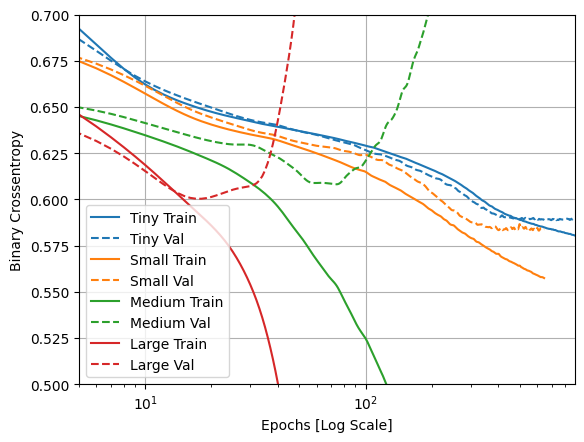

In [ ]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

注：上面运行的所有训练都使用了 `callbacks.EarlyStopping`，会在发现模型没有进展后终止训练。

### 在 TensorBoard 中查看

上述模型都会在训练期间写入 TensorBoard 日志。

在笔记本中打开嵌入式 TensorBoard 查看器（抱歉，这不会在 tensorflow.org 上显示）：

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

您可以在 [TensorBoard.dev](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) 上查看此笔记本[先前运行的结果](https://tensorboard.dev/)。

## 防止过拟合的策略

在开始学习本部分内容之前，请先复制上述 `"Tiny"` 模型的训练日志，用作比较基线。

In [ ]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmpfs/tmp/tmpjol485dc/tensorboard_logs/regularizers/Tiny')

In [ ]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### 添加权重正则化


您可能对奥卡姆剃刀法则很熟悉：对某件事给出两种解释，正确的解释往往是“最简单”的那个，即做出最少假设的那个解释。这也适用于神经网络学习的模型：给定一些训练数据和一个网络架构，有多组权重值（多个模型）可以解释数据，而简单模型比复杂模型更不容易过拟合。

在此上下文中，“简单模型”是指参数值的分布具有更少的熵的模型（或者是具有更少参数的模型，如上文中所见）。因此，缓解过拟合的一种常用方式是限制网络的复杂性，方法是强制网络的权重值只取较小值，这样会使权重值的分布更加“规则”。这被称为“权重正则化”，通过向网络的损失函数添加一个与较大权重相关的成本来实现。这种成本有两种方式：

- [L1 正则化](https://developers.google.com/machine-learning/glossary/#L1_regularization)，其中添加的成本与权重系数的绝对值（即权重的“L1 范数”）成正比。

- [L2 正则化](https://developers.google.com/machine-learning/glossary/#L2_regularization)，其中添加的成本与权重系数值的平方（即权重的“L2 范数”）成正比。L2 正则化在神经网络中也被称为权重衰减。不要因为名称不同而感到困惑：从数学角度来讲，权重衰减与 L2 正则化完全相同。

L1 正则化会促使权重向零靠近，鼓励稀疏模型。L2 正则化会惩罚权重参数而不使其稀疏化，因为对于较小权重，惩罚会趋近于零。这也是 L2 更为常见的一个原因。

在 `tf.keras` 中，添加权重正则化的方式是将权重正则化器实例作为关键字参数传递给层。添加 L2 权重正则化：

In [ ]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_14 (Dense)            (None, 512)               14848     


 dense_15 (Dense)            (None, 512)               262656    


 dense_16 (Dense)            (None, 512)               262656    


 dense_17 (Dense)            (None, 512)               262656    


 dense_18 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5065,  binary_crossentropy:0.8234,  loss:2.3574,  val_accuracy:0.4690,  val_binary_crossentropy:0.7087,  val_loss:2.1693,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6538,  binary_crossentropy:0.5950,  loss:0.6181,  val_accuracy:0.6600,  val_binary_crossentropy:0.5869,  val_loss:0.6104,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6698,  binary_crossentropy:0.5878,  loss:0.6107,  val_accuracy:0.6490,  val_binary_crossentropy:0.5856,  val_loss:0.6084,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6760,  binary_crossentropy:0.5773,  loss:0.6011,  val_accuracy:0.6860,  val_binary_crossentropy:0.5934,  val_loss:0.6170,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6817,  binary_crossentropy:0.5704,  loss:0.5935,  val_accuracy:0.6730,  val_binary_crossentropy:0.5789,  val_loss:0.6018,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6956,  binary_crossentropy:0.5655,  loss:0.5883,  val_accuracy:0.6800,  val_binary_crossentropy:0.5797,  val_loss:0.6025,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6991,  binary_crossentropy:0.5578,  loss:0.5825,  val_accuracy:0.6620,  val_binary_crossentropy:0.5858,  val_loss:0.6103,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

`l2(0.001)` 表示层的权重矩阵中的每个系数都会将 `0.001 * weight_coefficient_value**2` 添加到网络的总**损失**中。

这就是为什么我们要直接监视 `binary_crossentropy`，因为它没有混入此正则化组件。

因此，带有  `L2` 正则化惩罚的相同 `"Large"` 模型表现得更好：


(0.5, 0.7)

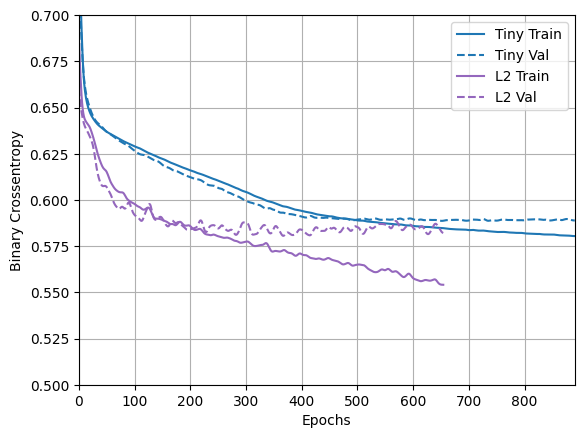

In [ ]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

如上图所示，`"L2"` 正则化模型现在比 `"Tiny"` 模型更具竞争力。`"L2"` 模型也比它所基于的 `"Large"` 模型（具有相同数量的参数）更不容易过拟合。

#### 更多信息

关于此类正则化，有两个重要的注意事项：

1. 如果您正在编写自己的训练循环，请务必询问模型的正则化损失。

In [ ]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

1. 此实现的工作方式是在模型的损失中添加权重惩罚，然后应用标准的优化程序。

还有一种方式，也就是仅在原始损失上运行优化器，然后在应用计算步骤的同时，优化器也应用一些权重衰减。此“解耦权重衰减”在 `tf.keras.optimizers.Ftrl` 和 `tfa.optimizers.AdamW` 等优化器中使用。

### 添加随机失活

随机失活是一种最有效、最常用的神经网络正则化技术，由 Hinton 和他在多伦多大学的学生共同开发。

随机失活的直观解释是，由于网络中的单个节点不能依赖其他节点的输出，所以每个节点必须输出对自己有用的特征。

应用于层时，随机失活会在训练期间对该层的多个输出特征进行随机“失活”（即设置为零）。例如，在训练期间，给定的层通常会为给定的输入样本返回一个 `[0.2, 0.5, 1.3, 0.8, 1.1]` 向量；应用随机失活后，该向量会有一些随机分布的零条目，例如 `[0, 0.5, 1.3, 0, 1.1]`。

“随机失活率”是指被清零的特征的比率；它通常设置为 0.2 到 0.5 之间。在测试时，没有单元会被随机失活，而是根据一个等于随机失活率的系数将层的输出值按比例缩小，进而实现平衡（因为会有更多单元在训练时被激活）。

在 Keras 中，您可以通过 `tf.keras.layers.Dropout` 层在网络中引入随机失活，该层将应用于前一层的输出。

向网络中添加两个随机失活层，检查它们在减少过拟合方面的表现：

In [ ]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_19 (Dense)            (None, 512)               14848     


 dropout (Dropout)           (None, 512)               0         


 dense_20 (Dense)            (None, 512)               262656    


 dropout_1 (Dropout)         (None, 512)               0         


 dense_21 (Dense)            (None, 512)               262656    


 dropout_2 (Dropout)         (None, 512)               0         


 dense_22 (Dense)            (None, 512)               262656    


 dropout_3 (Dropout)         (None, 512)               0         


 dense_23 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5053,  binary_crossentropy:0.7921,  loss:0.7921,  val_accuracy:0.5070,  val_binary_crossentropy:0.6695,  val_loss:0.6695,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6570,  binary_crossentropy:0.5956,  loss:0.5956,  val_accuracy:0.6810,  val_binary_crossentropy:0.5867,  val_loss:0.5867,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6863,  binary_crossentropy:0.5592,  loss:0.5592,  val_accuracy:0.6870,  val_binary_crossentropy:0.5787,  val_loss:0.5787,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.7270,  binary_crossentropy:0.5068,  loss:0.5068,  val_accuracy:0.6780,  val_binary_crossentropy:0.6100,  val_loss:0.6100,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

(0.5, 0.7)

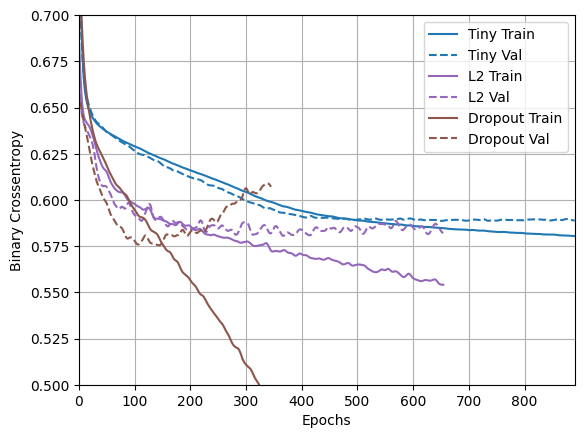

In [ ]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

从上面的绘图中可以清楚地看到，这两种正则化方法都改善了 `"Large"` 模型的行为，但依然没有超过 `"Tiny"` 基线。

接下来，将两者合起来试一试，看看效果是否更好。

### L2 + 随机失活的结合

In [ ]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_24 (Dense)            (None, 512)               14848     


 dropout_4 (Dropout)         (None, 512)               0         


 dense_25 (Dense)            (None, 512)               262656    


 dropout_5 (Dropout)         (None, 512)               0         


 dense_26 (Dense)            (None, 512)               262656    


 dropout_6 (Dropout)         (None, 512)               0         


 dense_27 (Dense)            (None, 512)               262656    


 dropout_7 (Dropout)         (None, 512)               0         


 dense_28 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5017,  binary_crossentropy:0.7937,  loss:0.9521,  val_accuracy:0.5170,  val_binary_crossentropy:0.6740,  val_loss:0.8317,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6385,  binary_crossentropy:0.6051,  loss:0.6348,  val_accuracy:0.6600,  val_binary_crossentropy:0.5836,  val_loss:0.6131,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6614,  binary_crossentropy:0.5896,  loss:0.6152,  val_accuracy:0.6830,  val_binary_crossentropy:0.5711,  val_loss:0.5968,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6766,  binary_crossentropy:0.5780,  loss:0.6065,  val_accuracy:0.6730,  val_binary_crossentropy:0.5641,  val_loss:0.5926,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6707,  binary_crossentropy:0.5786,  loss:0.6086,  val_accuracy:0.6870,  val_binary_crossentropy:0.5601,  val_loss:0.5901,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6854,  binary_crossentropy:0.5689,  loss:0.6007,  val_accuracy:0.6810,  val_binary_crossentropy:0.5577,  val_loss:0.5896,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6821,  binary_crossentropy:0.5669,  loss:0.6007,  val_accuracy:0.6970,  val_binary_crossentropy:0.5466,  val_loss:0.5804,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6897,  binary_crossentropy:0.5641,  loss:0.5996,  val_accuracy:0.7040,  val_binary_crossentropy:0.5417,  val_loss:0.5771,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.6867,  binary_crossentropy:0.5619,  loss:0.5990,  val_accuracy:0.6820,  val_binary_crossentropy:0.5556,  val_loss:0.5926,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 900, accuracy:0.7003,  binary_crossentropy:0.5502,  loss:0.5889,  val_accuracy:0.6930,  val_binary_crossentropy:0.5509,  val_loss:0.5896,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

(0.5, 0.7)

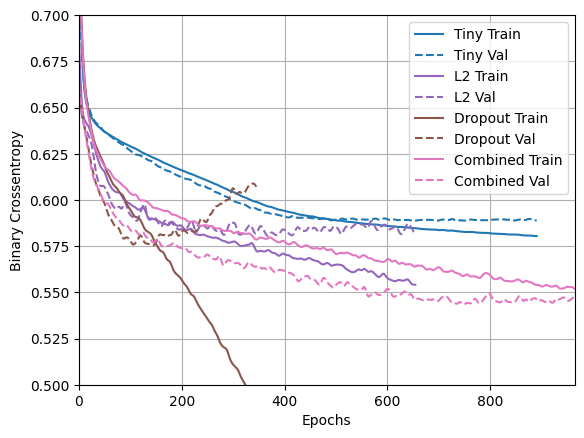

In [ ]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

这个使用 `"Combined"` 正则化的模型显然是目前为止最好的模型。

### 在 TensorBoard 中查看

这些模型也记录了 TensorBoard 日志。

要打开嵌入式查看器，请运行以下代码单元（抱歉，这不会在 tensorflow.org 上显示）：

In [ ]:
%tensorboard --logdir {logdir}/regularizers

您可以在 [TensorBoard.dev](https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97) 上查看此笔记本[先前运行的结果](https://tensorboard.dev/)。

## 结论

回顾一下，以下是在神经网络中防止过拟合的最常见方式：

- 获得更多训练数据。
- 降低网络容量。
- 添加权重正则化。
- 添加随机失活

本指南没有涵盖的两个重要方法是：

- [数据增强](../images/data_augmentation.ipynb)
- 批次归一化 (`tf.keras.layers.BatchNormalization`)

请记住，单独使用每种方法也会有效，但结合使用通常效果更好。